# Champions League Score Frequency

This script scrapes the champions league page based on the year which can be modified. It goes to the website using helium and collects all the matches and the goals scored by the home and away team.

At the end a bar graph is created showing the distribution of scores for that year. If you find any score particularly interesting , you can also enter the score at the last cell and the teams who played will be shown along with the results of the match

In [34]:
year = 2019
url = 'https://www.uefa.com/uefachampionsleague/history/seasons/'+str(year)+'/matches/'

In [35]:
from time import sleep , time
from helium import *
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns


In [36]:
class Match:
    def __init__(self,team1,score1,team2,score2):
        
        self.teams = [re.sub(r'\s+', '', team1),re.sub(r'\s+', '', team2)]

        if ( score1 == score2):
            self.winning_team = None
        else:
            self.winning_team = self.teams[0] if (int(score1) > int(score2)) else self.teams[1]

        self.score = score1 + ' - ' + score2
    
    def get_score(self):

        return self.score.split(' - ')

In [37]:
def wait_for_ajax(driver):
    wait = WebDriverWait(driver, 15)
    try:
        wait.until(lambda driver: driver.execute_script('return jQuery.active') == 0)
        wait.until(lambda driver: driver.execute_script('return document.readyState') == 'complete')
    except Exception as e:
        pass

Since the data is dynamically shown using javascript , we scroll down to the bottom in order to load all the data before saving the html file and using it to extract the matches to make sure we don't miss any of them.

In [38]:
try:
    browser = start_chrome(url,headless=True)
    for _ in range(5):

        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        sleep(1.5)
        

    html = browser.page_source

    soup = BeautifulSoup(html,'html.parser')
except:
    print('There was an error getting to the page')
    print('make sure you entered the year correctly i.e. 2017')


In [39]:
matches = soup.find_all('div',{'class':'match-row_match'})

In [40]:
print('There were {} matches played at the {}'.format(len(matches),year))

There were 150 matches played at the 2019


In [41]:
My_Matches = []
for match in matches:
    score = match.find('div',{'class':'match--score_score'}).text.split('-')
    home_team = match.find('div',{'class':'team-home'}).div.div.span.text
    away_team = match.find('div',{'class':'team-away'}).div.div.span.text
    My_Matches.append(Match(team1=home_team,score1=score[0][1:],team2=away_team,score2=score[1][:-1]))


In [42]:
M = len(My_Matches)
N = 4

X = np.zeros((M,N),dtype='object')

for  i , match in enumerate(My_Matches):
    X[i,0] = match.teams[0]
    X[i,1] = match.teams[1]
    X[i,2] , X[i,3] = match.get_score()

In [43]:
cols = ['Home','Away','Home Score','Away Score']
df = pd.DataFrame(X,columns=cols)

In [44]:
df_temp = df[['Home Score','Away Score']].astype(int)
df['scores'] = df_temp.max(axis=1).astype('str') + ' - '+ df_temp.min(axis=1).astype('str')

In [45]:
vals , counts = np.unique(df['scores'],return_counts=True)

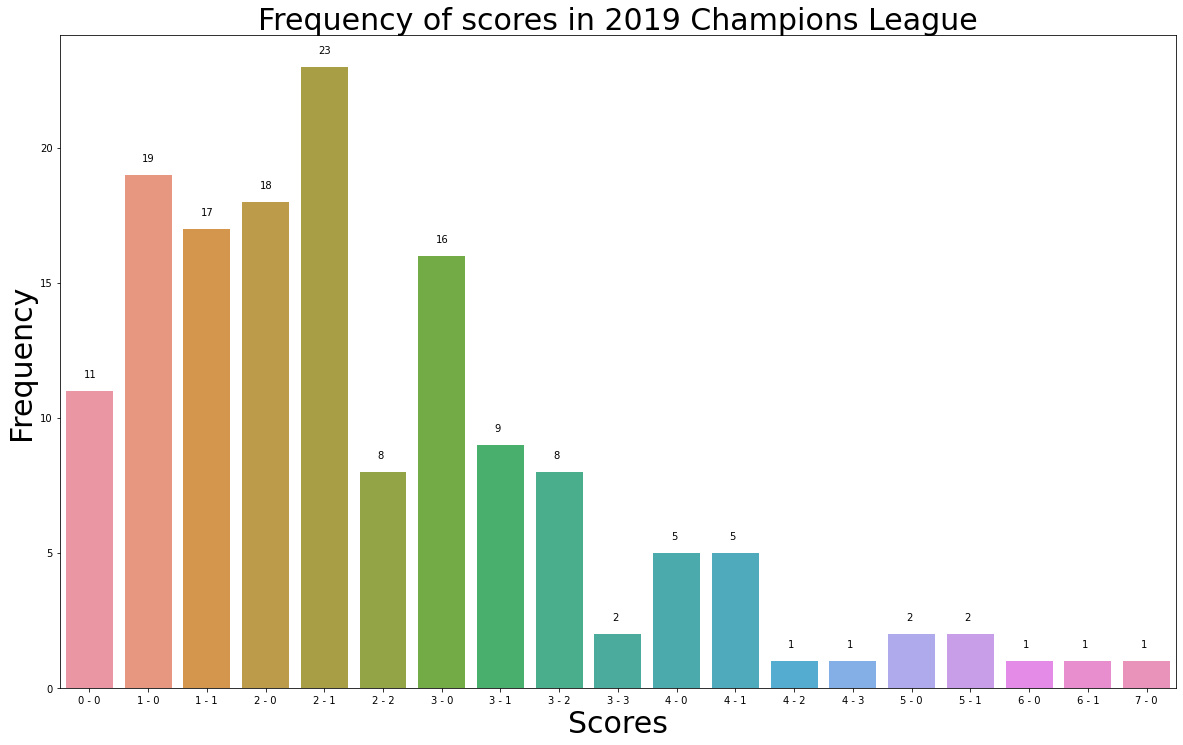

In [46]:
plt.figure(figsize=(20,12))
plt.title("Frequency of scores in {} Champions League".format(year))
ax = sns.barplot(x=vals,y=counts)
plt.xlabel('Scores', size = 30)
plt.ylabel('Frequency', size = 30)
plt.title('Frequency of scores in {} Champions League'.format(year), size = 30)

for i , p in enumerate(ax.patches):
    ax.annotate('{}'.format(int(p.get_height())), (p.get_x()+0.3, p.get_height()+0.5))


In [47]:
def find_match_with_score(score1,score2,columns=cols,x=df):
    mask1 = np.logical_and(df['Home Score'] == str(score1),df['Away Score'] == str(score2))
    mask2 = np.logical_and(df['Home Score'] == str(score2),df['Away Score'] == str(score1))
    return df[np.logical_or(mask1,mask2)][cols]

In [48]:
find_match_with_score(5,0)

,Home,Away,Home Score,Away Score
62,Plzeň,RealMadrid,0,5
102,Roma,Plzeň,5,0
